In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from pandas.plotting import autocorrelation_plot

import numpy as np
from pandas import Series

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMAResults 
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import _arma_predict_out_of_sample

from sklearn.metrics import r2_score

In [2]:
dataset_title = 'Lamb Price USA'


def _plot_(xlabel, ylabel, data, draw_horizontal_mean, plot_title):
    plt.figure(figsize=(15, 10))

    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    
    if draw_horizontal_mean:
        plt.axhline(data.mean(), color='k', linestyle='dashed', linewidth=1)
    
    if plot_title:
        plt.plot(data, label = dataset_title)
    else:
        plt.plot(data)
    
    plt.xticks(rotation=90)
    ax = plt.gca()
    temp = ax.xaxis.get_ticklabels() 
    temp = list(set(temp) - set(temp[::6]))

    for label in temp:
        label.set_visible(False)

    plt.legend(loc=4, prop={'size': 16})

In [3]:
location = 'https://raw.githubusercontent.com/nlucian/time-series-analysis/master/meat_prices_usa.csv'

In [4]:
def load_data_and_rename_columns(initial_date_column, initial_price_column, location):
    csv = pd.read_csv(location)
    csv = csv.rename(columns={initial_date_column:'Date'})
    csv = csv.rename(columns={initial_price_column:'Price'})
    return csv

In [5]:
initial_data = load_data_and_rename_columns('Month', 'Lamb price', location)
initial_data = initial_data[initial_data.Price.notnull()]

In [6]:
def process_initial_ds(dataset):
    pd.to_datetime(dataset.Date.str.upper(), format='%b-%y')
    dataset = dataset.set_index('Date')
    return dataset

In [7]:
initial_ds_processed = process_initial_ds(initial_data)
initial_ds_processed.head(2)

,Chicken Price,Chicken price % Change,Beef Price,Beef price % Change,Price,Lamb price % Change,Pork Price,Pork price % Change,Salmon Price,Salmon price % Change
Date,,,,,,,,,,
Apr-90,1.08,NaN,2.47,NaN,2.63,NaN,99.64,NaN,5.63,NaN
May-90,1.08,0.00%,2.48,0.40%,2.71,3.04%,115.68,16.10%,5.80,3.02%


In [8]:
initial_data_processed_df = initial_ds_processed['Price']

No handles with labels found to put in legend.


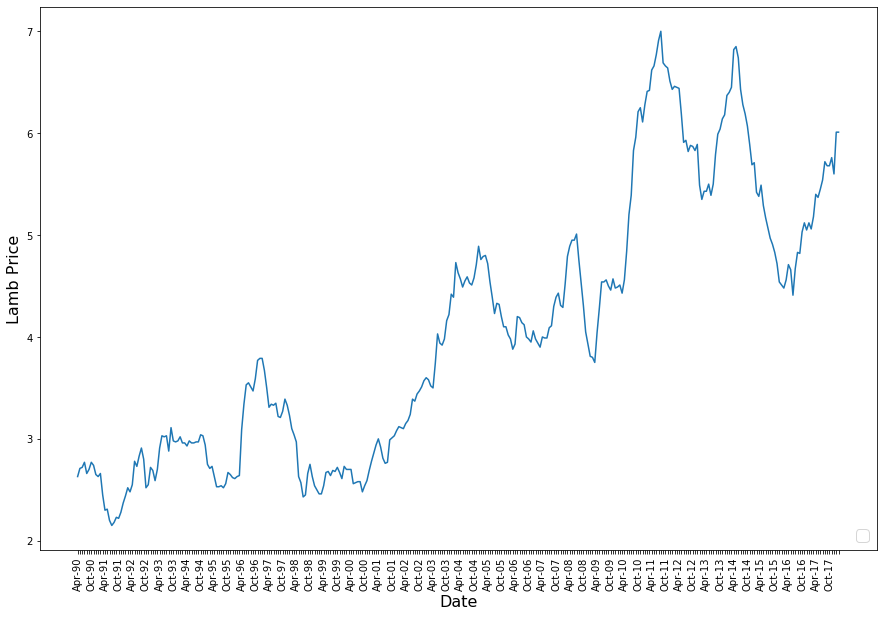

In [9]:
_plot_('Date', 'Lamb Price', initial_data_processed_df, False, False)

In [10]:
 plot_lag = 40

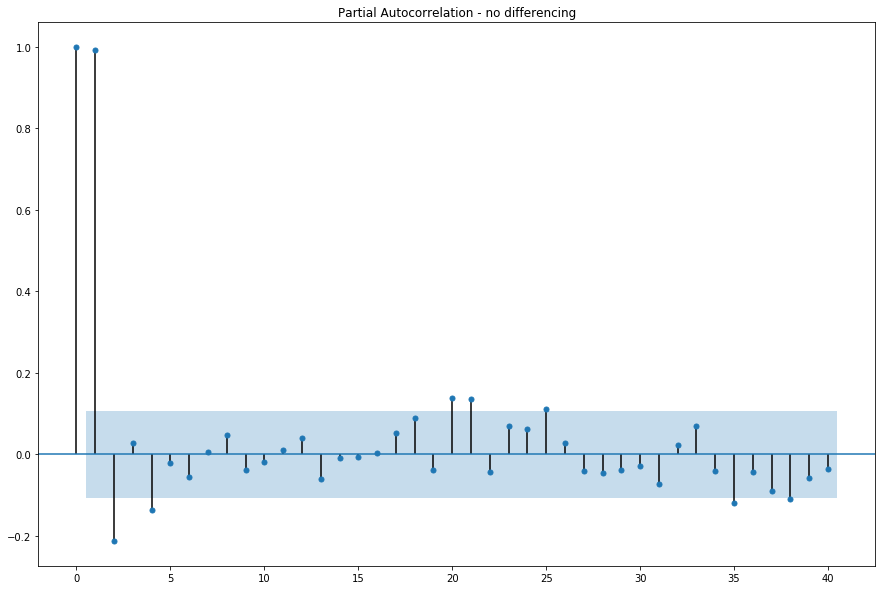

In [11]:
trash_var = plot_pacf(initial_ds_processed['Price'], lags=plot_lag)
plt.title('Partial Autocorrelation - no differencing')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)

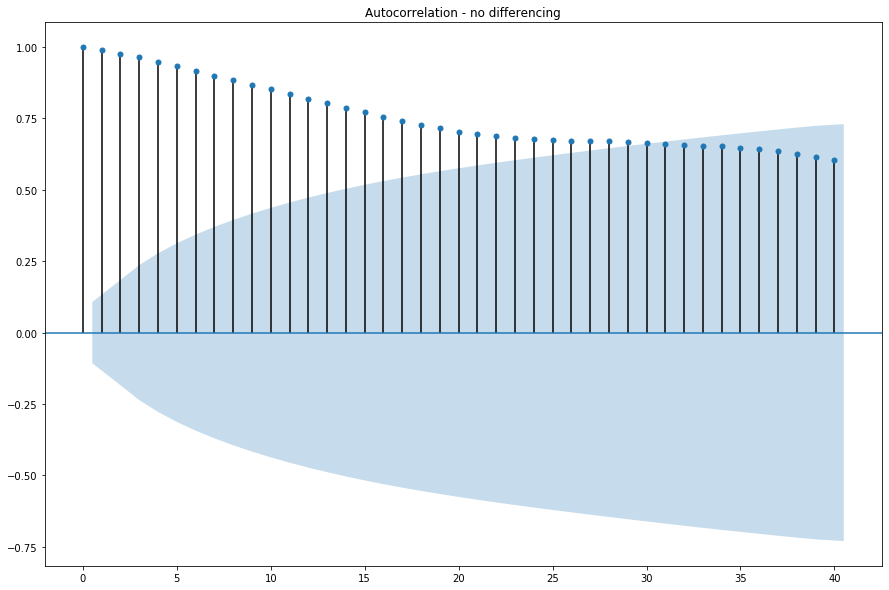

In [12]:
trash_var = plot_acf(initial_data_processed_df, lags=plot_lag)
plt.title('Autocorrelation - no differencing')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)

In [13]:
z = initial_ds_processed.copy()

In [14]:
ds_indexed_differentiated_price = z['Price'] - z['Price'].shift()
ds_indexed_differentiated_price[0] = 0

No handles with labels found to put in legend.


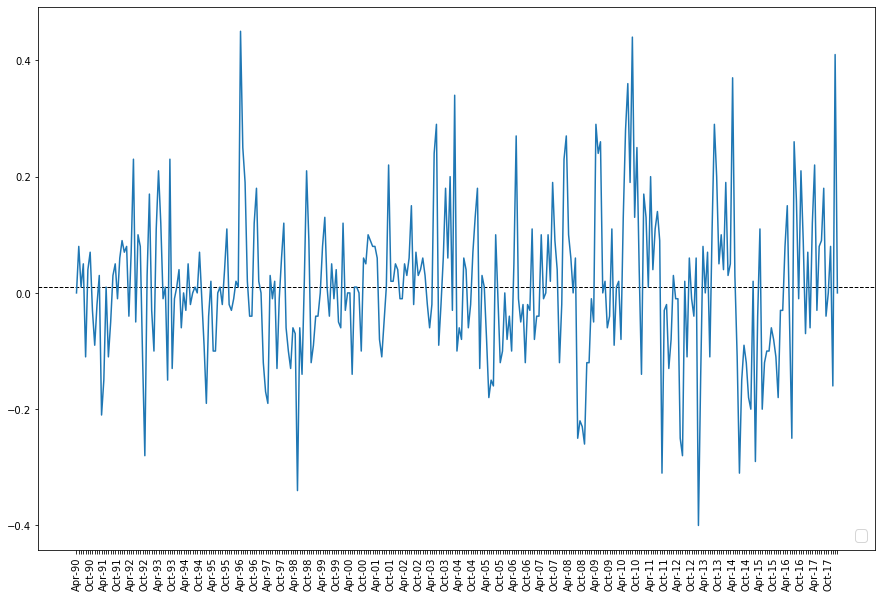

In [15]:
_plot_('', '', ds_indexed_differentiated_price, True, False)

In [16]:
len(range(0, len(ds_indexed_differentiated_price)))
len(ds_indexed_differentiated_price)

335

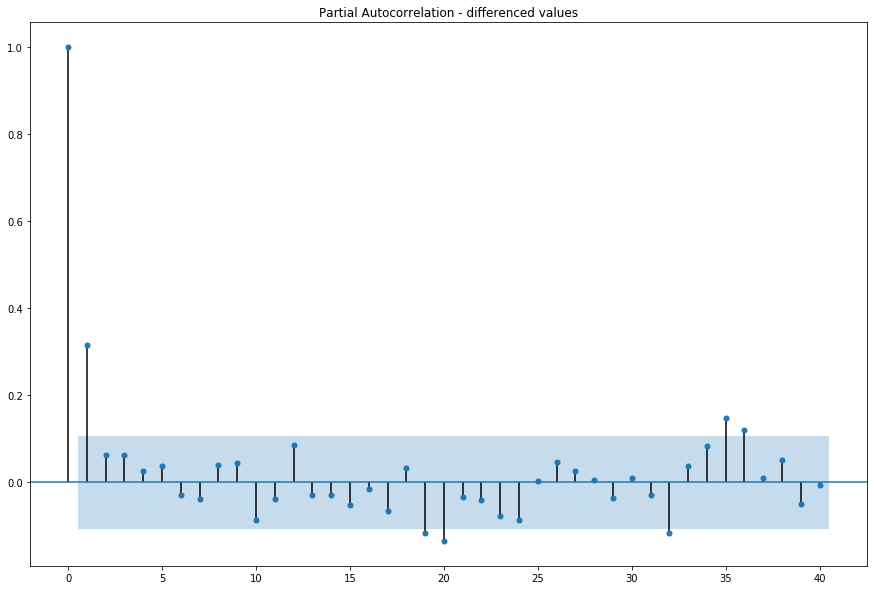

In [17]:
trash_var = plot_pacf(ds_indexed_differentiated_price, lags=plot_lag)
plt.title('Partial Autocorrelation - differenced values')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)

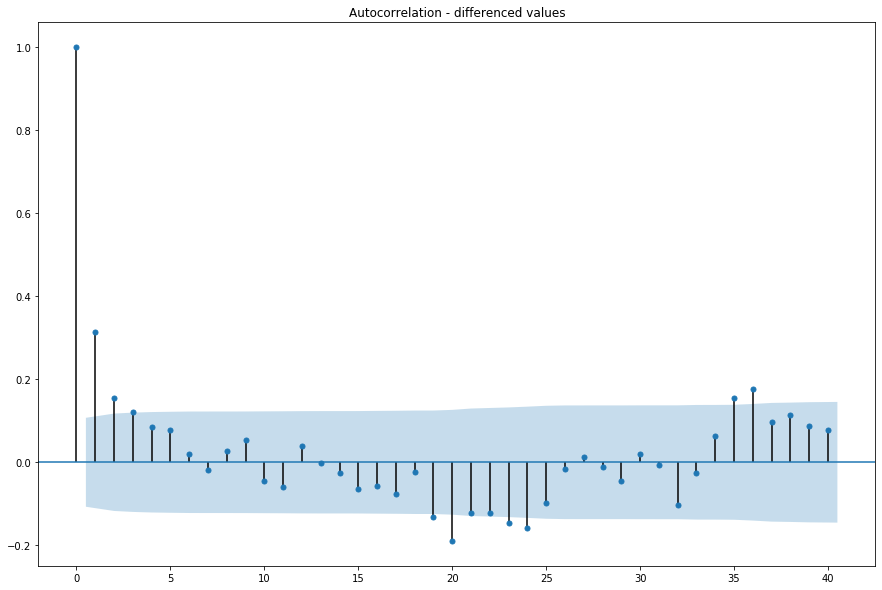

In [18]:
trash_var = plot_acf(ds_indexed_differentiated_price, lags=plot_lag)
plt.title('Autocorrelation - differenced values')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)

In [19]:
def stationarity_test(data):
    result = adfuller(data)
    print('p-value: {}'.format(result[1]))

In [20]:
stationarity_test(initial_data_processed_df)

p-value: 0.7542089947062343


In [21]:
stationarity_test(ds_indexed_differentiated_price)

p-value: 1.3512468714205496e-24


In [22]:
initial_data_processed_df.describe()

count    335.000000
mean       4.038299
std        1.296284
min        2.150000
25%        2.805000
50%        3.940000
75%        4.900000
max        7.000000
Name: Price, dtype: float64

In [23]:
ds_indexed_differentiated_price.describe()

count    335.000000
mean       0.010090
std        0.128265
min       -0.400000
25%       -0.060000
50%        0.000000
75%        0.075000
max        0.450000
Name: Price, dtype: float64

In [24]:
size_before = int(len(initial_data_processed_df) / 2)

In [25]:
split1_before_df = initial_data_processed_df[:size_before]
split2_before_df = initial_data_processed_df[size_before:]

In [26]:
print("BEFORE differencing - split1_before_df.mean: {} | split2_before_df.mean: {}".format(split1_before_df.mean(), split2_before_df.mean()))

BEFORE differencing - split1_before_df.mean: 2.949161676646707 | split2_before_df.mean: 5.120952380952379


In [27]:
size = int(len(ds_indexed_differentiated_price) / 2)

In [28]:
split1 = ds_indexed_differentiated_price[:size]
split2 = ds_indexed_differentiated_price[size:]

In [29]:
print("AFTER differencing - split1.mean: {} | split2.mean: {}".format(split1.mean(), split2.mean()))

AFTER differencing - split1.mean: 0.0125748502994012 | split2.mean: 0.007619047619047616


In [30]:
model = ARMA(ds_indexed_differentiated_price, order = (19, 1)).fit()

/Users/lucian.nut/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [31]:
prediction_result = model.predict()

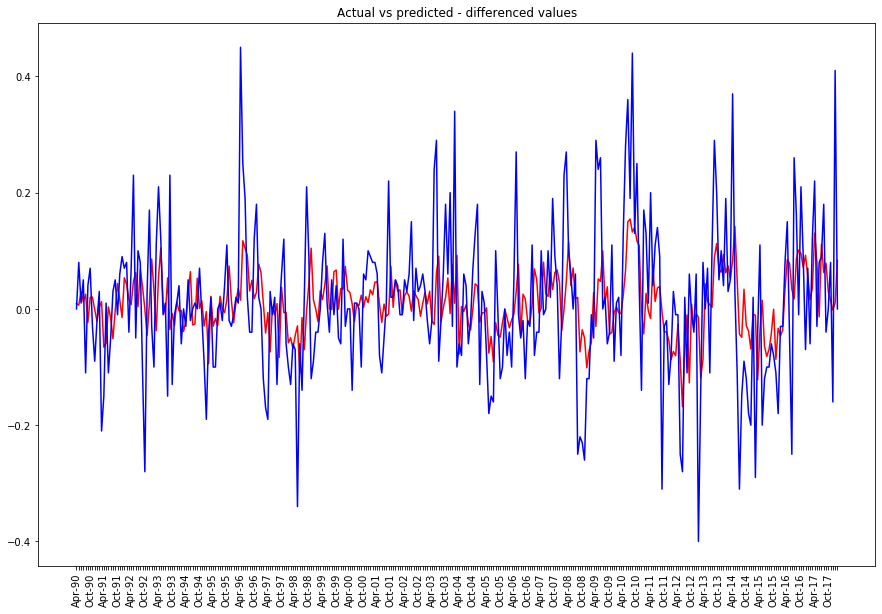

In [32]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
plt.plot(prediction_result, 'r')
plt.plot(ds_indexed_differentiated_price, 'b')
plt.title("Actual vs predicted - differenced values")
plt.xticks(rotation=90)
ax = plt.gca()
temp = ax.xaxis.get_ticklabels() 
temp = list(set(temp) - set(temp[::6]))
for label in temp:
    label.set_visible(False)

In [52]:
reversed_pred = [z['Price'][0]]
reversed_pred

[2.63]

In [53]:
prediction_result

Date
Apr-90    0.009395
May-90    0.006481
Jun-90    0.029490
Jul-90    0.011657
Aug-90    0.025218
            ...   
Oct-17    0.029601
Nov-17    0.014725
Dec-17   -0.001891
Jan-18    0.010774
Feb-18    0.083311
Length: 335, dtype: float64

In [33]:
reversed_pred = [z['Price'][0]]

c = 1

while(c < len(prediction_result)):
    reversed_pred.append(reversed_pred[c-1] + prediction_result[c])
    c+=1

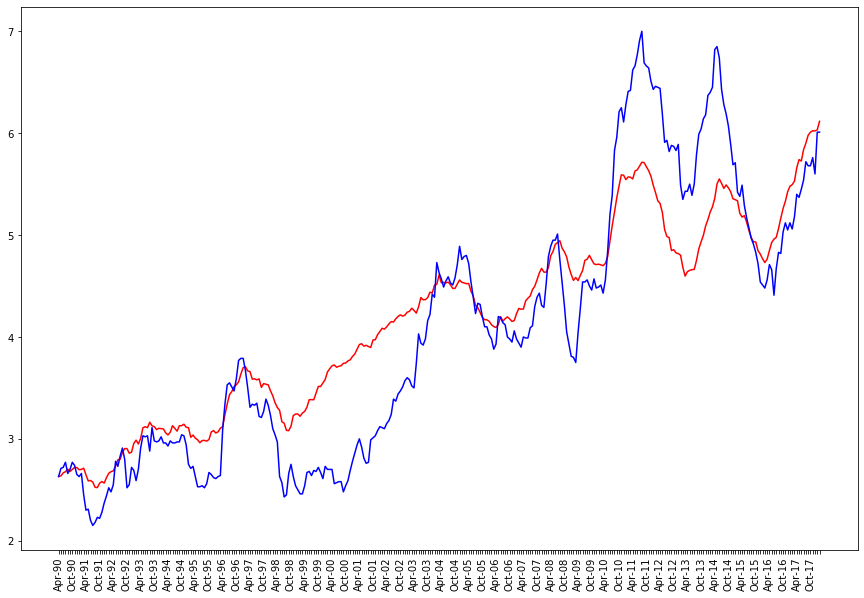

In [34]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)
plt.plot(reversed_pred, 'r')
plt.plot(z['Price'], 'b')

plt.xticks(rotation=90)
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::6]))

for label in temp:
    label.set_visible(False)

In [35]:
r2_score(z['Price'], reversed_pred)

0.7998060875824053

In [36]:
mean_squared_error(z['Price'], reversed_pred)

0.3353919310966698

In [37]:
model.aic

-442.5428717363724

In [38]:
# reference 
# https://stackoverflow.com/questions/18616588/arma-out-of-sample-prediction-with-statsmodels

days_to_predict = 20

p = model.k_ar
q = model.k_ma

k_exog = model.k_exog
k_trend = model.k_trend

In [39]:
next_20_days = _arma_predict_out_of_sample(model.params, days_to_predict, model.resid, p, q, k_trend, k_exog, endog=ds_indexed_differentiated_price, exog=None, start=len(ds_indexed_differentiated_price))

In [40]:
initial_ds_processed['Price'][-1] + next_20_days[0]

5.995316171169065

In [41]:
predicted_values_to_plot = []
predicted_values_to_plot.append(initial_ds_processed['Price'][-1] + next_20_days[0])

In [42]:
predicted_values_to_plot

[5.995316171169065]

In [43]:
for i in range(1, days_to_predict):
    predicted_values_to_plot.append(predicted_values_to_plot[i-1] + next_20_days[i])

In [45]:
forecast_days = np.arange(len(initial_ds_processed), len(initial_ds_processed) + len(predicted_values_to_plot) + 1)

In [46]:
forecast_days

array([335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347,
       348, 349, 350, 351, 352, 353, 354, 355])

In [48]:
predicted_values_to_plot.insert(0, initial_ds_processed['Price'][-1])

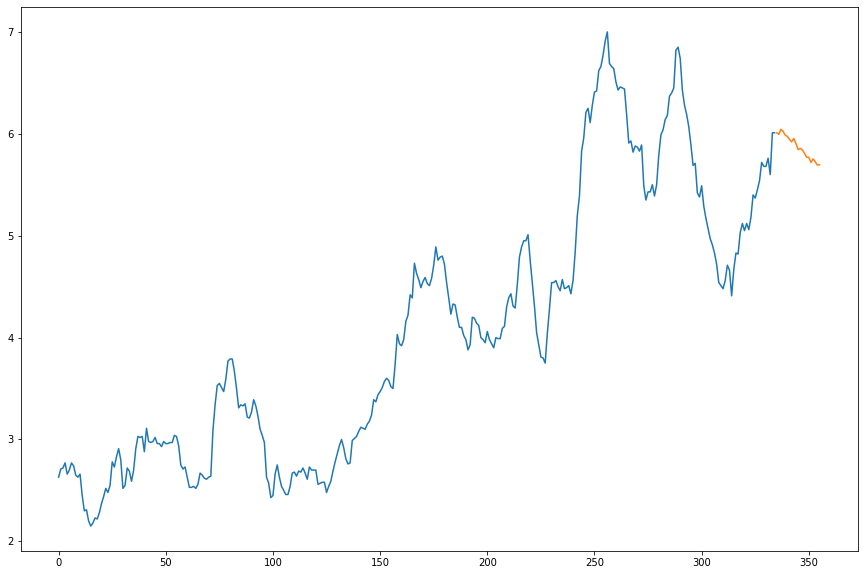

In [50]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15, 10)

plt.plot(initial_ds_processed['Price'].values, label = 'Actual Values')
plt.plot(forecast_days, predicted_values_to_plot, label = 'Predicted Values')